**余盈蓓；語碩二；110555009**\
**111-2 Computational Linguistics**
<p align="center", style = "font-size:18pt">
<b>2nd Assignment<br>
Naive Bayes</b>
</p>

<p align="center">
以下將使用從<a href = "https://www.kaggle.com/datasets/niraliivaghani/flipkart-product-customer-reviews-dataset" target="_blank">Kaggle</a>取得的<a href = "https://www.flipkart.com/" target = "_blank">線上購物網站－Flipkart</a>上，消費者對商品的評論資料，以Naive Bayes實作情感分析。<br>
<br>

<p style = "font-size:14pt">
<b>Step 1. 資料前處理</b>
</p>
<p style = "font-size:12pt">
✨資料讀入
</p>

In [3]:
import pandas as pd

data = pd.read_csv("data.csv")

In [4]:
data.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205049 entries, 0 to 205048
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   205049 non-null  object
 1   product_price  205049 non-null  int64 
 2   Rate           205049 non-null  int64 
 3   Review         180385 non-null  object
 4   Summary        205038 non-null  object
 5   Sentiment      205049 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.4+ MB


<p style = "font-size:12pt">
✨資料簡述<br>
&emsp;&ensp;該dataset中包含下列六個column：<br>
&emsp;&ensp;🎲 產品名稱<br>
&emsp;&ensp;🎲 產品價格<br>
&emsp;&ensp;🎲 消費者評分：消費者對商品的滿意度評分（1~5分）<br>
&emsp;&ensp;🎲 固化評語：消費者根據網站提供模板選取針對產品的評價<br>
&emsp;&ensp;🎲 消費者評論：消費者針對商品親自撰寫的評價<br>
&emsp;&ensp;🎲 評論正負向：資料提供者根據消費者評論給予的分類，包含positive, negative, neutral三種<br>
</p>

<p style = "font-size:12pt">
✨NA值處理<br>
</p>

In [6]:
clean_data = data.dropna(axis=0).reset_index(drop = True)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180376 entries, 0 to 180375
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   180376 non-null  object
 1   product_price  180376 non-null  int64 
 2   Rate           180376 non-null  int64 
 3   Review         180376 non-null  object
 4   Summary        180376 non-null  object
 5   Sentiment      180376 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.3+ MB


<p style = "font-size:12pt">
✨去除分類為neutral的資料<br>
&emsp;&ensp;因為分類為neutral的評論在資料中只佔5%，為了避免資料不平衡造成的問題，這邊直接把分類為neutral資料拿掉，專注做正負向情感分析。
</p>

In [7]:
drop_list = []
index_counter = 0

for label in clean_data["Sentiment"]:
  if label != "positive" and label != "negative":
    drop_list.append(index_counter)
  index_counter += 1

In [8]:
clean_data = clean_data.drop(index = drop_list, axis = 0)
clean_data = clean_data.reset_index(drop=True)

In [9]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171569 entries, 0 to 171568
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_name   171569 non-null  object
 1   product_price  171569 non-null  int64 
 2   Rate           171569 non-null  int64 
 3   Review         171569 non-null  object
 4   Summary        171569 non-null  object
 5   Sentiment      171569 non-null  object
dtypes: int64(2), object(4)
memory usage: 7.9+ MB


In [10]:
clean_data["Sentiment"].value_counts()

positive    147169
negative     24400
Name: Sentiment, dtype: int64

<p style = "font-size:14pt">
<b>Step 2. 特徵萃取</b>
</p>
<p style = "font-size:12pt">
✨情感分數計算<br>
&emsp;&ensp;以下使用<code>nltk</code>中提供的<code>vader</code>套件計算每一則評論情感分數。<br>
&emsp;&ensp;<code>vader</code>的使用不需要經過斷詞就可以操作，而且他會偵測否定詞出現與否來調整分數，基本上比我們用字典計算詞頻還要完善，可惜好像不能針對中文文本使用。
</p>

In [11]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

<p style = "font-size:12pt">
&emsp;&ensp;輸出的結果是一個包含正向分數、負向分數、中立分數跟綜合分數的字典，如下所示：
</p>

In [12]:
experiment_sentence = "I am not happy with this."
sid = SentimentIntensityAnalyzer() # 初始化工具
score = sid.polarity_scores(experiment_sentence)
score

{'neg': 0.428, 'neu': 0.572, 'pos': 0.0, 'compound': -0.4585}

<p style = "font-size:12pt">
&emsp;&ensp;這次取用正向分數、負向分數跟綜合分數來作為特徵，分別看評論的正向情緒傾向、負向情緒傾向跟整體情緒傾向是不是都會影響到模型判斷。
</p>

In [13]:
positive_score = []
negative_score = []
sentiment_score = []

for comment in clean_data["Summary"]:
    result = sid.polarity_scores(comment)
    positive_score.append(result["pos"])
    negative_score.append(result["neg"])
    sentiment_score.append(result["compound"])

In [14]:
clean_data["positive_score"] = positive_score
clean_data["negative_score"] = negative_score
clean_data["sentiment_score"] = sentiment_score

<p style = "font-size:12pt">
✨特徵、答案分離<br>
</p>

In [15]:
features = clean_data.drop(["product_name", "product_price", "Review", "Summary", "Sentiment"], axis = 1) 
label = clean_data[["Sentiment"]]
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171569 entries, 0 to 171568
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Rate             171569 non-null  int64  
 1   positive_score   171569 non-null  float64
 2   negative_score   171569 non-null  float64
 3   sentiment_score  171569 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 5.2 MB


<p style = "font-size:12pt">
✨轉換名義變項<br>
</p>

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label["Sentiment"] = label[["Sentiment"]].apply(LabelEncoder().fit_transform)
label.head()

C:\Users\c5227\AppData\Local\Temp\ipykernel_16648\3560148433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label["Sentiment"] = label[["Sentiment"]].apply(LabelEncoder().fit_transform)


,Sentiment
0,1
1,1
2,1
3,0
4,1


<p style = "font-size:12pt">
✨區分訓練集、測試集<br>
</p>

In [17]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size = 0.2, random_state = 100)

<p style = "font-size:14pt">
<b>Step 3. 模型訓練</b>
</p>
<p style = "font-size:12pt">
✨單純Naive Bayes訓練<br>
&emsp;&ensp;因為特徵都是數值資料，所以選用高斯分布的Naive Bayes套件來訓練模型。
</p>

In [18]:
from sklearn.naive_bayes import GaussianNB
import numpy as np
model = GaussianNB()
raw_NB = model.fit(feature_train, np.ravel(label_train))

<p style = "font-size:14pt">
<b>Step 4. 結果評估</b>
</p>
<p style = "font-size:12pt">
✨單純Naive Bayes預測<br>
</p>

In [19]:
NB_prediction = raw_NB.predict(feature_test)

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

# 寫成function之後比較好用

def model_metrics(prediction, label): # 定義一個新功能叫做model_metrics，裡面需要prediction跟label兩個參數。然後作下面這然後做下面這些事情
    
    print(ConfusionMatrixDisplay.from_predictions(label, prediction, cmap = "Wistia")) # 印出混淆矩陣
    evaluation = precision_recall_fscore_support(label, prediction, average='micro') # 計算precision, recall, F-score
    accuracy = accuracy_score(label, prediction) # 計算accuracy

    # 印出評估結果
    print("accuracy: " + str(round(accuracy, 2)) + "\nprecision: " + str(round(evaluation[0], 2)) + "\nrecall: " + str(round(evaluation[1], 2)) + "\nfscore: " + str(round(evaluation[2],2)))

accuracy: 0.98
precision: 0.98
recall: 0.98
fscore: 0.98


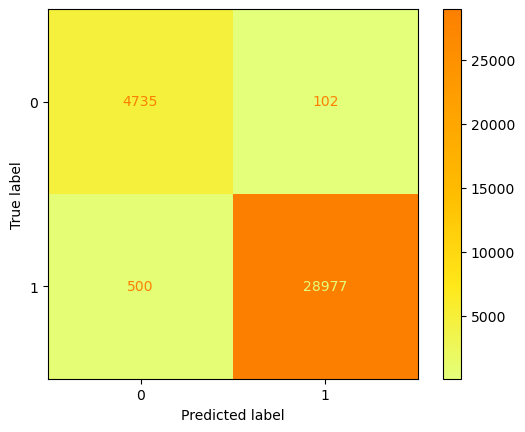

In [21]:
model_metrics(NB_prediction, label_test)

<p style = "font-size:12pt">
✨10-fold Cross Validation<br>
</p>

In [22]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(model, feature_train, np.ravel(label_train), cv=10, scoring='f1_micro'))
print("平均值："+str(np.mean(cross_val_score(model, feature_train, np.ravel(label_train), cv=10, scoring='f1_micro'))))

[0.98236923 0.97916363 0.98083928 0.98236923 0.98164068 0.98251366
 0.98025501 0.9779235  0.97923497 0.9820765 ]
平均值：0.9808385691654014


<p style = "font-size:12pt">
✨Bootstrapping<br>
</p>

In [71]:
200/len(feature_test)

0.0058285248003730255

<p style = "font-size:12pt">
&emsp;&ensp;從上面的數字可以看出bootstrapping的起始比例應該至少是testset的0.06<br>
&emsp;&ensp;為了計算方便，這裡將起始比例設為0.103，每次往上增加0.03。這樣做完300次就會剛好是1<br>
&emsp;&ensp;0.103+0.03*299=1
</p>

In [72]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import random

平均f-score：0.982424832298478


<AxesSubplot:xlabel='sample', ylabel='f-score'>

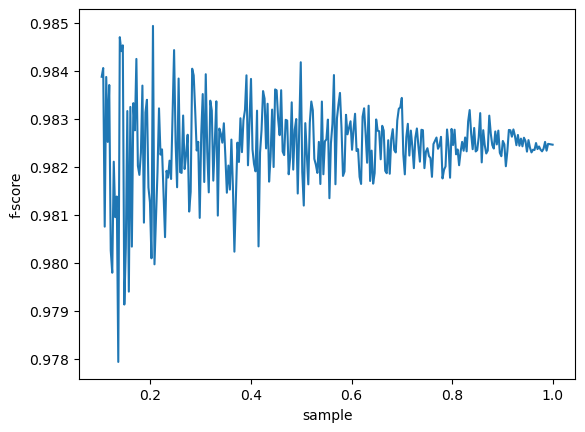

In [69]:
data_list = []
score = []
for iteration in range(300):
        seed = random.randint(1,1000)
        fraction = iteration*0.003+0.103
        feature_bs = feature_test.sample(frac = fraction, random_state = seed)
        label_bs = label_test.sample(frac = fraction, random_state = seed)
        prediction = model.predict(feature_bs)
        fscore = precision_recall_fscore_support(label_bs, prediction, average='micro')[2]
        score.append(fscore)
        data_list.append([fraction, fscore])
print("平均f-score：" + str(np.mean(score)))

#畫圖
data = pd.DataFrame(data_list, columns = ["sample", "f-score"])

sns.lineplot(
data=data, x="sample", y="f-score")

<p style="font-size:12pt">
&emsp;&ensp;乍看之下這張圖似乎沒有達到收斂，呈現不穩定的起伏，但仔細看y軸的部分會發現他只畫出0.978~0.985的區間。因此我們可以把y軸的範圍重新調成0~1。
</p>

(0.0, 1.0)

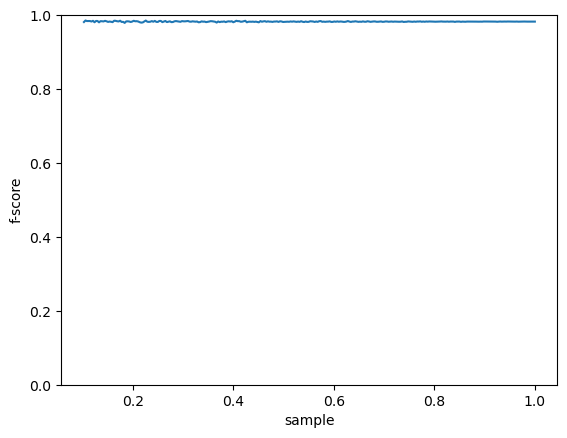

In [68]:
sns.lineplot(
data=data, x="sample", y="f-score").set_ylim(0,1)

<p align = "center", style = "font-size:16pt">
    🧐<b>討論</b>🧐<br>
</p>
<p style = "font-size:12pt">
   從cv跟bootstrapping的結果可以看到，他們都跟單純使用Naive Bayes直接以test set評估的結果差不多（f-score落在0.98左右）。尤其是從上圖可以發現，從我們第一次取樣的時候，f-score就已經是收斂的狀態了。會這樣可能是因為bootstrapping跟cv的使用大部分是為了應對資料量太小的問題。而我這次使用的資料共171569筆，所以即便是在兩個類別分配極度不均的情況下，模型的表現還是維持在一定的程度。（當然也有<code>nltk</code>套件寫得好的功勞）這個部分也可以從同樣達到0.98的recall跟precision得到驗證。
</p>
